# Coherence Change Detection using `ifgramStack.h5`

**Created by: Marin Govorcin, Feb 17, 2022**

This notebook shows how we can use the coherence stack in `inputs/ifgramStack.h5` file for a change or damage detection after natural hazard event, e.g. earthquakes, volcano eruption, flooding, etc.

Coherence change detection (CCD) is obtained as a relative coherence loss between the "normal" pre-event and co-event coherence. Pre-event coherence is calculated for two Synthetic Aperture Radar (SAR) SLCs acquired before the event, whereas a co-event coherence is obtained between one before and one SAR SLC image after the event.

### Relevant literature:

1. Yun, et al. (2015a): Rapid Damage Mapping for the 2015 Mw 7.8 Gorkha Earthquake Using Synthetic Aperture Radar Data fromCOSMO–SkyMed and ALOS-2 Satellites, Seismological Research Letters, https://pubs.geoscienceworld.org/srl/article/86/6/1549-1556/315478

2. Yun et al. (2015b): DAMAGE PROXY MAP FROM INTERFEROMETRIC SYNTHETIC APERTURE RADAR COHERENCE, United States Patent US 9.207,318 B2, https://patents.google.com/patent/US9207318

3. Washaya, et al. (2018): Coherence Change-Detection with Sentinel-1 for Natural and Anthropogenic Disaster Monitoring in Urban Areas, Remote Sensing, http://www.mdpi.com/2072-4292/10/7/1026

4. Stephenson et al. (2021): Deep Learning -based Damage Mapping with InSAR Coherence Time Series, IEEE Transactions on Geoscience and Remote Sensing, https://ieeexplore.ieee.org/document/9467551

* if you want to try it..some info on RNN can be found on https://www.tensorflow.org/guide/keras/rnn


In [85]:
%matplotlib inline
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

from mintpy import geocode, save_kmz
from mintpy.objects import ifgramStack
from mintpy.utils import readfile, writefile, utils as ut


##############################  Utilities Functions  ######################################
def calc_coherence_change(cohStack, date12List, eventDate, method='diff',
                         startDate=None, subset=None, thresh = None, mask = None, plot=False):
    """
    Calculate Coherence Change for the defined event (earthquake, volcano eruption, flooding)

    Input:
      cohStack      ::  ndarray    - timeseries coherence stack
      date12List    ::  list       - dates of SAR acquistions used to generate coherence, example: '20170828_20170904'
      eventDate     ::  str        - date of the event for which CCD is calculated, example: '20170904'
                                    (event: earthquake, volcano eruption, flooding)
      startDate     ::  str        - define the first date to get reference, pre-coherence stack: [startDate:eventDate], default is first date of timeseries
      subset        ::  list       - calculate CCD on image subset defined as [x1,x2,y1,y2]
      method        ::  str        - method for calculate CCD:
                                     'diff' : difference between mean pre- and co- coherence
                                     'hist' : histogram matching using pre-event coherence as reference (Yun et al. 2015a and Yun et al. 2015b)
                                     'rtio' : ratio between pre- & co- coherence stack (Washaya, et al. 2018)
      thresh        ::  float/list - mean spatial coherence threshold used to refine the pre-coherence stack
      mask          ::  float      - mask value, used to mask the CCD values below the defined value
      plot          ::  bool       - [True/False] plot intermediate steps (default = False)

    Output:
      ccd           ::  array - Coherence Change Detection 
      pre_coherence ::  array - Mean Pre-Event Coherence, i.e. before the event
      co_coherence  ::  array - Mean Co-Event Coherence, i.e. during the event
    """
    
    print('\n###############################################')
    print('########## Coherence Change Detection #########')
    print('###############################################\n')

    # If startDate is not defined, use the first date in timeseries
    if startDate is None:
        startDate = date12List[0]

    if subset is None:
        subset = [0,cohStack.shape[2],0,cohStack.shape[1]]

    ##### FIND and EXTRACT THE NEEDED DATA
    #initilize variables
    preEvent_ix = []
    coEvent_ix  = []

    print('Get pre-event and co-event coherence data')
    # Find coherence datasets before the Event from the start date (defined or begining of timeseries)
    # and  coherence dateset covering the Event: reference SAR acquisition before and secondary after the Event
    for ix,date12 in enumerate(date12List):
        if date12.split('_')[0] < eventDate and date12.split('_')[0] > startDate and date12.split('_')[1] < eventDate:
            preEvent_ix.append(ix)
        elif date12.split('_')[0] < eventDate and date12.split('_')[1] > eventDate:
            coEvent_ix.append(ix)   
  
    # Coherence stacks
    pre_cohStack = cohStack[preEvent_ix,subset[2]:subset[3],subset[0]:subset[1]]
    co_cohStack  = cohStack[coEvent_ix,subset[2]:subset[3],subset[0]:subset[1]]
              
    # Refinement
    if thresh is not None:
        print('Refine pre-event Coherence Stack:')
        pre_cohStack_bt = pre_cohStack
        mean_coh_bt = np.nanmean(pre_cohStack,axis=(1,2))
        #thresh can be manually defined as list of dates to keep
        if isinstance(thresh,list) is True:
            pre_cohStack = np.take(pre_cohStack,thresh,axis=0)
        else:
            ix = np.where(mean_coh_bt > thresh)
            pre_cohStack = np.take(pre_cohStack,ix[0],axis=0)
            print('List of dates to keep:')
            print(ix[0])
        print(f'Number of pre-Event Datasets After Thresholding: {pre_cohStack.shape[0]}')
        mean_coh = np.nanmean(pre_cohStack,axis=(1,2))

        if plot is not False:
            fig, axs = plt.subplots(1, 2, figsize=(8,4),dpi=100)
            img1 = axs[0].hist(mean_coh_bt,bins=50,density=False)
            img2 = axs[1].hist(mean_coh,bins=20,density=False)
            axs[0].title.set_text('Pre-Event Coherence Before Thresh.')
            axs[1].title.set_text('Pre-Event Coherence After Thresh.')
            axs[0].set_ylabel('# Images')
            axs[0].set_xlabel('Avg. Spatial Coherence')
            axs[1].set_ylabel('# Images')
            axs[1].set_xlabel('Avg. Spatial Coherence')
            
            fig1, axs1 = plt.subplots(1, 2, figsize=(8,8),dpi=100)
            img3 = axs1[0].imshow(np.mean(pre_cohStack_bt,axis=0),cmap='gray', clim=[0,1])
            img4 = axs1[1].imshow(np.mean(pre_cohStack,axis=0),cmap='gray', clim=[0,1])
            axs1[0].title.set_text('Pre-Coherence. Before Thresh.')
            axs1[1].title.set_text('Pre-Coherence After Thresh.')
   
    # Mean pre-event and co-event stack coherence
    pre_coherence = np.mean(pre_cohStack,axis=0)
    co_coherence  = np.mean(co_cohStack,axis=0)
    
    ##### CCD
    print('\nCoherence Change Detection Calculation')
    # 1. Difference between mean pre_event coh.  - mean. co_event coh.
    if method == 'diff':
        print('     Method: Difference')
        ccd = pre_coherence - co_coherence
            
    # 2. Histogram matching (Yun et al. 2015a and Yun et al. 2015b) between mean pre_event coh.(ref image) and mean co_event  coh. (matched image.)
    elif method == 'hist':
        print('     Method: Histogram Matching')
        ccd = 1 - exposure.match_histograms(co_coherence, pre_coherence, multichannel=False)       
    
    # 3. Ratio between pre- & co-event coherence stack (Washaya, et al. 2018):
    elif method == 'rtio':
        print('     Method: Ratio')
        ccd = (pre_coherence - co_coherence) / co_coherence * 100
    else:
        print('Unknown method!, Exit the CCD calculation')
        sys.exit()
        
    # Mask
    if mask is not None:
        print('Masking CCD values below {}'.format(mask))
        ccd= np.ma.filled(np.ma.masked_where(ccd< mask,ccd),fill_value=np.nan)
    
    print('Finish CCD calculation. Output: ccd, pre_coherence, co_coherence')
    return ccd, pre_coherence, co_coherence


def plot_ccd(ccd_data, eventDate, subset=None, method='diff', thresh = None, title=True, colorbar=True):
    """Plot coherence change detection results."""
    if ccd_data.ndim > 2:
        nimg = ccd_data.shape[0]
    else:
        nimg = 1
    
    fig, axs = plt.subplots(1, nimg,figsize=(10,12),dpi=100)
    
    if subset is None:
        subset = [0,cohStack.shape[2],0,cohStack.shape[1]]
    
    for i, method in enumerate(methods):   
        if method == 'diff':
            method = 'Difference'
        elif method == 'hist':
            method = 'Histogram Matching'
        elif method == 'rtio':
            method = 'Ratio'
        else:
            method = ''

        if nimg == 1:
            img = axs.imshow(ccd_data[subset[2]:subset[3],subset[0]:subset[1]], cmap='RdGy_r')
            if colorbar == True:
                fig.colorbar(img,ax=axs,location='bottom', pad=0.05)
        else:
            img = axs[i].imshow(ccd_data[i][subset[2]:subset[3],subset[0]:subset[1]], cmap='RdGy_r')
            if colorbar == True:
                fig.colorbar(img,ax=axs[i],location='bottom', pad=0.05)

        if title == True:
            if thresh is not None:
                txt = f'CCD on {eventDate} \n {method} \n w/ thresh. {thresh}'
            else:
                txt = f'CCD on {eventDate} \n {method}'
            if nimg ==1:
                axs.title.set_text(txt)
            else:
                axs[i].title.set_text(txt)

    return
    

# 1. Coherence Change Calculation

open ifgramStack file: ifgramStack.h5
reading coherence data from file: /home/marin/Downloads/FernandinaSenDT128/mintpy/inputs/ifgramStack.h5 ...

###############################################
########## Coherence Change Detection #########
###############################################

Get pre-event and co-event coherence data

Coherence Change Detection Calculation
     Method: Difference
Finish CCD calculation. Output: ccd, pre_coherence, co_coherence

###############################################
########## Coherence Change Detection #########
###############################################

Get pre-event and co-event coherence data

Coherence Change Detection Calculation
     Method: Histogram Matching
Finish CCD calculation. Output: ccd, pre_coherence, co_coherence

###############################################
########## Coherence Change Detection #########
###############################################

Get pre-event and co-event coherence data

Coherence Change Detect

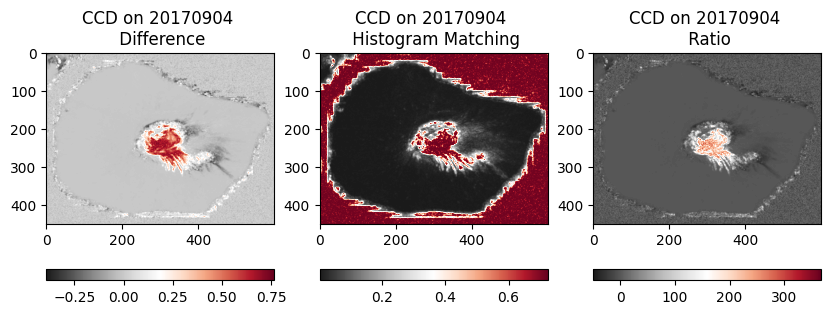

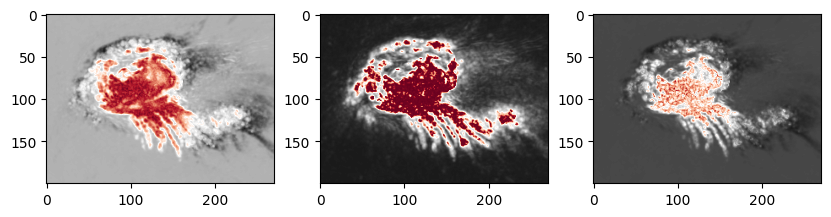

In [73]:
# Change directory to your work_dir
work_dir  = os.path.expanduser('~/Downloads/FernandinaSenDT128/mintpy')
os.chdir(work_dir)

# Define input parameters
stack     = os.path.join(work_dir,'inputs/ifgramStack.h5')
geom_file = os.path.join(work_dir,'inputs/geometryRadar.h5')

# Event: vulcano Fernandina eruption on Sep 04. 2017 
eventDate = '20170904' 
startDate = '20150101'

stackObj = ifgramStack(stack)
stackObj.open()

# Get the coherence date list
date12List = stackObj.date12List

# Get coherence stack from ifgramStack.h5
cohStack  = stackObj.read(datasetName='coherence')

# Calculate CCD using three different approaches:
ccd_data =  []
pre_coherence_data =  []
co_coherence_data  =  []
methods = ['diff','hist','rtio']

for mthd in enumerate(methods):
    ccd, pre_coherence, co_coherence = calc_coherence_change(cohStack, date12List,eventDate,\
                           startDate='20150101',method=mthd[1],thresh=None,plot=False)
    ccd_data.append(ccd)
    pre_coherence_data.append(pre_coherence)
    co_coherence_data.append(co_coherence)

# Plot CCD results
plot_ccd(np.asarray(ccd_data),eventDate, method=methods)

# zoom in the affected area
plot_ccd(np.asarray(ccd_data), eventDate, subset=[200, 470, 150, 350],method=methods, title=False, colorbar=False)

# 2. Refine CCD results with pre-event coherence thresholding


###############################################
########## Coherence Change Detection #########
###############################################

Get pre-event and co-event coherence data
Refine pre-event Coherence Stack:
List of dates to keep:
[ 99 117 120 123 125 139 144 150 153]
Number of pre-Event Datasets After Thresholding: 9

Coherence Change Detection Calculation
     Method: Difference
Finish CCD calculation. Output: ccd, pre_coherence, co_coherence


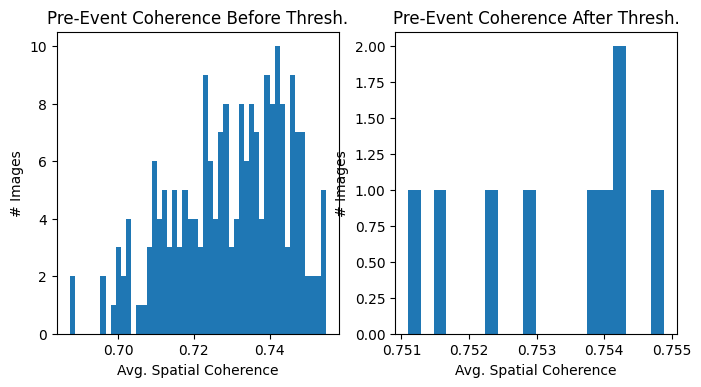

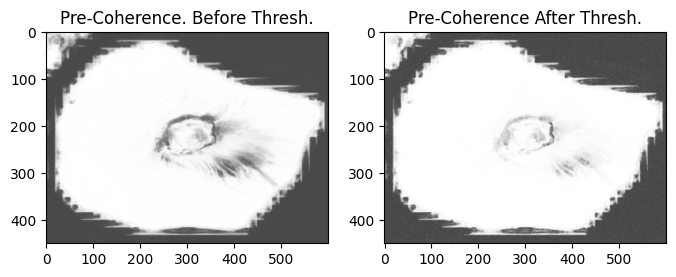

In [86]:
#######################################################################################
#########################       THRESHOLDING       ####################################
#######################################################################################

# CCD with threshold value 0.75, i.e. remove datasets with mean spatial coherence below the defined threshold
threshold = 0.75
ccd, pre_coherence, co_coherence = calc_coherence_change(cohStack, date12List,eventDate,\
                           startDate='20150101',method=methods[0],thresh=threshold,plot=True)

# Intermediate plots show an improvement in the pre_coherence around the volcano crater.



###############################################
########## Coherence Change Detection #########
###############################################

Get pre-event and co-event coherence data
Refine pre-event Coherence Stack:
List of dates to keep:
[ 99 117 120 123 125 139 144 150 153]
Number of pre-Event Datasets After Thresholding: 9

Coherence Change Detection Calculation
     Method: Difference
Finish CCD calculation. Output: ccd, pre_coherence, co_coherence

###############################################
########## Coherence Change Detection #########
###############################################

Get pre-event and co-event coherence data
Refine pre-event Coherence Stack:
List of dates to keep:
[ 99 117 120 123 125 139 144 150 153]
Number of pre-Event Datasets After Thresholding: 9

Coherence Change Detection Calculation
     Method: Histogram Matching
Finish CCD calculation. Output: ccd, pre_coherence, co_coherence

###############################################
########## Cohere

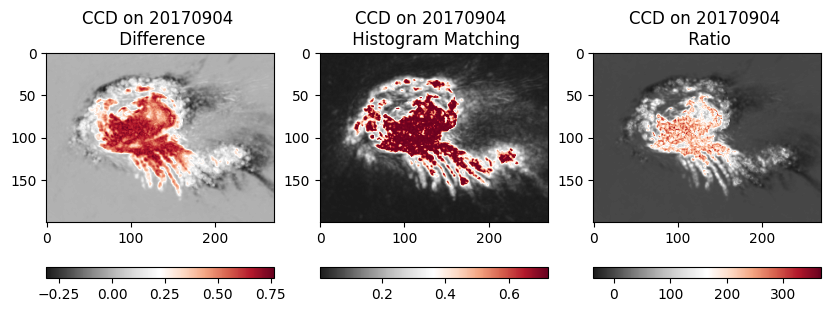

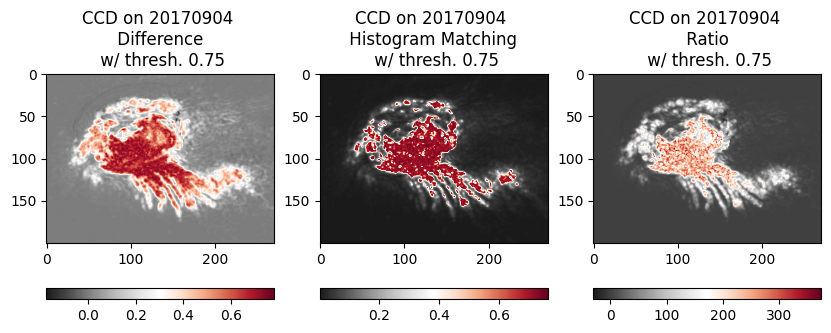

In [77]:
# Calculate CCD using three different approaches with threshold 0.75:
ccd_data2 =  []
pre_coherence_data2 =  []
co_coherence_data2  =  []
methods = ['diff','hist','rtio']

for mthd in enumerate(methods):
    ccd, pre_coherence, co_coherence = calc_coherence_change(cohStack, date12List,eventDate,\
                           startDate='20150101',method=mthd[1],thresh=threshold,plot=False)
    ccd_data2.append(ccd)
    pre_coherence_data2.append(pre_coherence)
    co_coherence_data2.append(co_coherence)
    
# Plot CCD results for the affected area before Thresholding
plot_ccd(np.asarray(ccd_data),eventDate, subset=[200, 470, 150, 350],method=methods, title=True, colorbar=True)

# Plot CCD results for the affected area after Thresholding
plot_ccd(np.asarray(ccd_data2),eventDate, subset=[200, 470, 150, 350],method=methods, thresh = threshold, title=True, colorbar=True)

# 3. Mask and export CCD result to kmz


###############################################
########## Coherence Change Detection #########
###############################################

Get pre-event and co-event coherence data
Refine pre-event Coherence Stack:
List of dates to keep:
[ 99 117 120 123 125 139 144 150 153]
Number of pre-Event Datasets After Thresholding: 9

Coherence Change Detection Calculation
     Method: Difference
Masking CCD values below 0.25
Finish CCD calculation. Output: ccd, pre_coherence, co_coherence

###############################################
########## Coherence Change Detection #########
###############################################

Get pre-event and co-event coherence data
Refine pre-event Coherence Stack:
List of dates to keep:
[ 99 117 120 123 125 139 144 150 153]
Number of pre-Event Datasets After Thresholding: 9

Coherence Change Detection Calculation
     Method: Histogram Matching
Masking CCD values below 0.4
Finish CCD calculation. Output: ccd, pre_coherence, co_coherence

######

'/home/marin/Downloads/FernandinaSenDT128/mintpy/geo_cohChange_CCD_diff-092017.kmz'

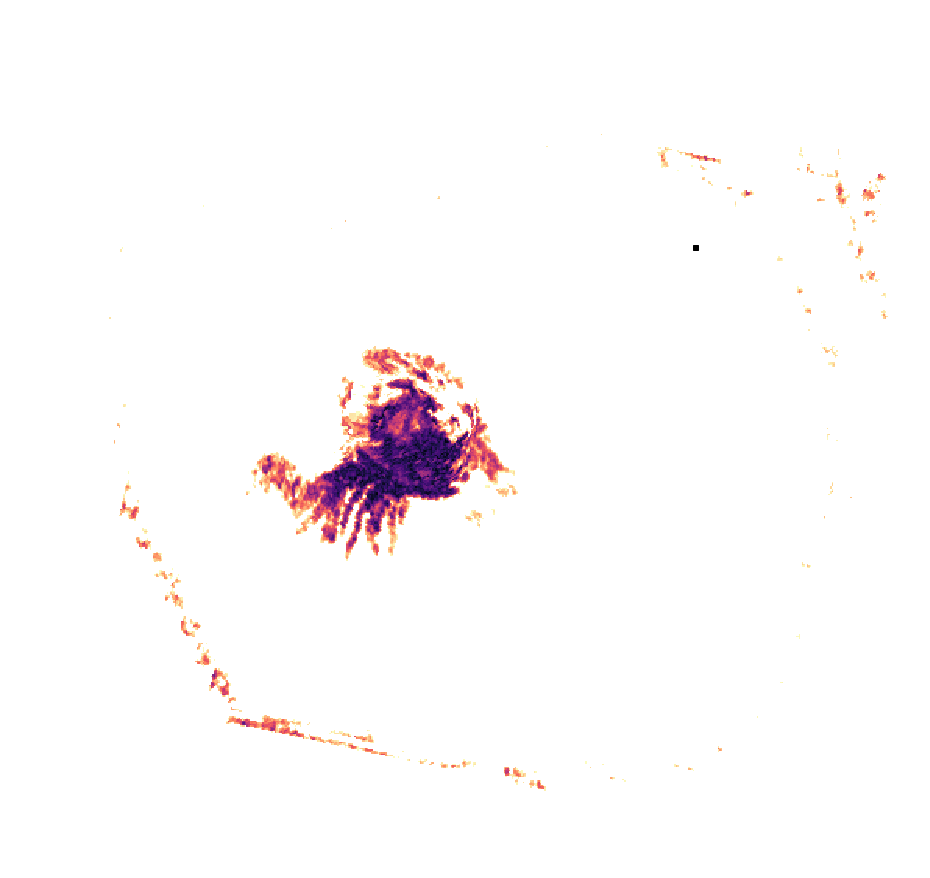

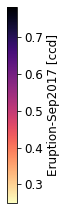

In [82]:
#######################################################################################
##########################       MASKING       ########################################
#######################################################################################
'''
Mask not representative pixels values for the coherence change / damage
'''

# Calculate CCD using three different approaches with threshold 0.75 and mask
ccd_data3 =  []
pre_coherence_data3 =  []
co_coherence_data3  =  []
methods = ['diff','hist','rtio']
msk    = [0.25,0.4,170]

for mthd in enumerate(methods):
    ccd, pre_coherence, co_coherence = calc_coherence_change(cohStack, date12List,eventDate,\
                           startDate='20150101',method=mthd[1],thresh=threshold,mask=msk[mthd[0]], plot=False)
    ccd_data3.append(ccd)
    pre_coherence_data3.append(pre_coherence)
    co_coherence_data3.append(co_coherence)

#######################################################################################
########################       WRITE RESULTS       ####################################
#######################################################################################

# Write the results to h5
attr = readfile.read_attribute(stack)

dsDict = {}
dsDict['CCD_diff-092017'] = ccd_data3[0]
dsDict['CCD_hist-092017'] = ccd_data3[1]
dsDict['CCD_ratio-092017'] = ccd_data3[2]

attr['FILE_TYPE'] = 'coherence'
attr['PROCESOR'] = 'isce'
attr['LENGTH'] = np.asarray(ccd_data3).shape[1]
attr['WIDTH'] = np.asarray(ccd_data3).shape[2]

writefile.write(dsDict,out_file='cohChange_Fernandina-0917.h5',metadata=attr)

#######################################################################################
########################       GEOCODE RESULTS       ##################################
#######################################################################################

geocode.main(f'cohChange_Fernandina-0917.h5 -l {geom_file}'.split())

#######################################################################################
#####################       EXPORT RESULTS TO KMZ       ###############################
#######################################################################################

save_kmz.main('geo_cohChange_Fernandina-0917.h5 CCD_diff-092017 --cbar-label Eruption-Sep2017 -u CCD -c magma_r'.split())

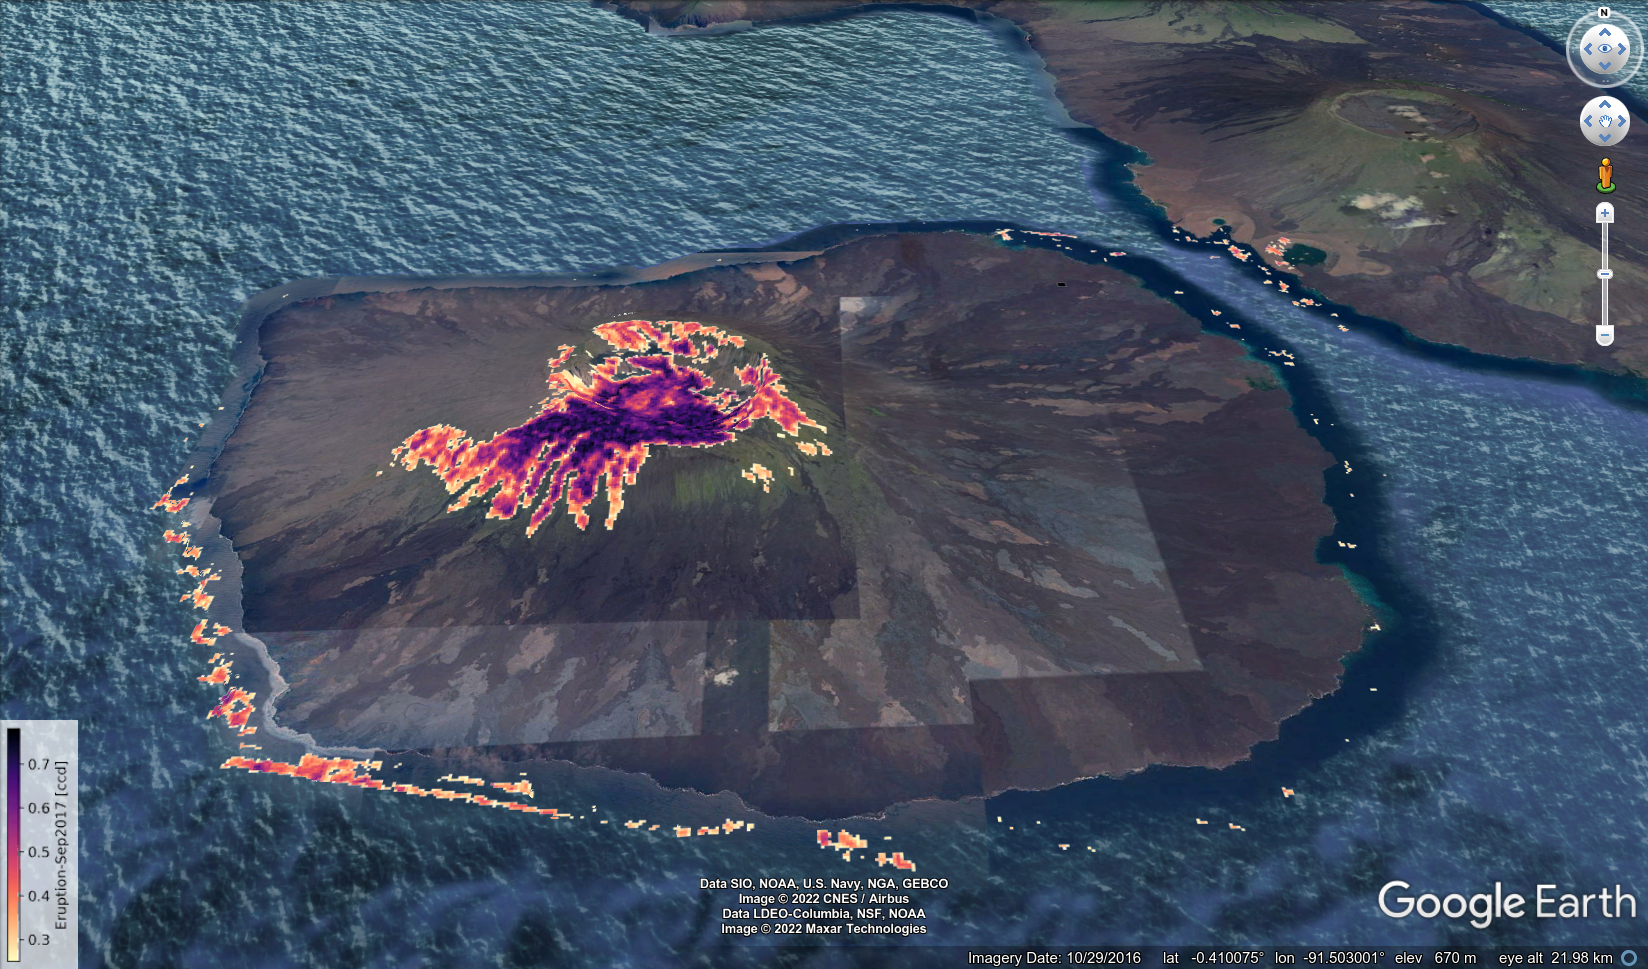

In [87]:
from IPython.display import Image

Image("Fernandina_eruptionSep2017.png")